# Sprint ディープラーニングフレームワーク2
# １．公式Example
深層学習フレームワークには公式に様々なモデルのExampleコードが公開されています。

# 【問題1】公式Exampleを分担して実行
TensorFLowの公式Exampleを分担して実行してください。                     
以下の中から1人ひとつ選び実行し、その結果を簡単に発表してください。
### research
定番のモデルから最新のモデルまで多様なコードが公開されています。                           
https://github.com/tensorflow/models/tree/master/research                             
### tutorials
TensorFLowのチュートリアルとして用意された簡単なモデルが含まれています。                      
https://github.com/tensorflow/models/tree/master/tutorials                    

## 事前学習済みのConvNetを使用した転移学習
このチュートリアルでは、事前に訓練されたネットワークからの転移学習を使用して、猫と犬の画像を分類する方法について説明します。これにより、ネットワークをゼロからトレーニングすることで、見たよりも高い精度を得ることができます。

**事前訓練されたモデル**は、以前に、典型的には大規模な画像分類タスクに、大きなデータセットで訓練された保存されたネットワークです。事前学習済みのモデルをそのまま使用するか、事前学習済みの修道院を使用して学習を移行できます。**転移学習**の背後にある直観は、このモデルが大きく一般的な十分なデータセットでトレーニングされた場合、このモデルは視覚世界の一般的なモデルとして効果的に機能するということです。タスクに固有の独自のモデルの基礎としてこれらのモデルを使用することにより、大きなデータセットで大きなモデルをトレーニングする必要なく、これらの学習された機能マップを活用できます。                    
                     
事前学習済みモデルを使用した転移学習には2つのシナリオがあります。

### 1.特徴抽出 
-以前のネットワークで学習した表現を使用して、新しいサンプルから意味のある特徴を抽出します。事前学習済みモデルの上に、ゼロから学習する新しい分類子を追加するだけで、データセット用に以前に学習した特徴マップを再利用できます。事前学習済みモデル全体を使用しますか、それとも畳み込みベースのみを使用しますか？-これらの事前トレーニングされたconvnet（畳み込みベース）の特徴抽出部分を使用します。これは、これらが一般的な特徴であり、画像上の概念を学習する可能性が高いためです。ただし、事前学習済みモデルの分類部分は、多くの場合、元の分類タスクに固有であり、その後、モデルが学習されたクラスのセットに固有です。
### 2.Fine Tuning
-特徴抽出に使用される凍結モデルベースの最上層のいくつかの凍結を解除し、新しく追加された分類レイヤーと凍結モデルの最後のレイヤーの両方を共同でトレーニングします。これにより、最終的な分類子に加えて高次のフィーチャ表現を「微調整」して、関連する特定のタスクにより関連するようにすることができます。                                     
一般的な機械学習のワークフローに従います。                                  
1.データを調べて理解する                             
2.入力パイプラインを構築する-画像分類チュートリアルで行ったようにKeras ImageDataGeneratorを使用します                                
3.モデルを作成する                            
* 事前学習済みのモデル（および事前学習済みの重み）を読み込む
* 上に分類レイヤーを積み重ねる
4.モデルを訓練する                            
5.モデルを評価する                        
                       
事前にトレーニングされたconvnetを特徴抽出として使用し、ベースモデルの最後の数層をトレーニングするために微調整する例を見ていきます。


## 転移学習とは（自分なりの解釈）
* 転移学習とは、すでに学習したモデルを別の領域に適応させる技術のこと      
* 何も知らない赤ちゃん状態から学習するより，その領域のことはあんま知らなくても，ある程度教育受けてる大人の方が学習するのは早いよね，って話．
* ImageNetという大規模なデータセット学習した1000種類の画像を分類できるモデルを利用して，イヌorネコを分類する            
                                          
### 転移学習には大きく分けて二つのやり方がある。                   
１． 訓練済みモデルの出力層に近い側のパラメータのみ訓練し、上流のパラメータは固定する。                  
     →再訓練に使えるデータセットの規模が非常に小さい場合や、訓練時間を短縮したい場合に用いる。（今回コッチ）            
２．訓練済みモデルの全てのパラメータを再訓練する。                          
→**ファインチューニング**と呼び、通常はこちらの方が高い精度が得られやすい。
### 転移学習のプロセス
* 第一段：入力画像から、特徴量(ボトルネック特徴量)を抽出する
* 第二段：ボトルネック特徴量を用いて、クラス分類をする

In [33]:
from __future__ import absolute_import, division, print_function, unicode_literals

import os

import tensorflow as tf
from tensorflow import keras
print("TensorFlow version is ", tf.__version__)

import numpy as np

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

TensorFlow version is  1.14.0


### データのダウンロード-cats_and_dogs_filtered.zip                         
KaggleのDogs vs Catsデータセットのフィルターバージョンをダウンロードします。次に、ダウンロードしたzipファイルを「/ tmp /」ディレクトリに保存します。

In [34]:
zip_file = tf.keras.utils.get_file(origin="https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip",
                                   fname="cats_and_dogs_filtered.zip", extract=True)
base_dir, _ = os.path.splitext(zip_file)

### 猫と犬のデータセットのトレーニングと検証を準備する
猫のデータセットと犬のデータセットのトレーニングおよび検証ディレクトリを作成します。

In [35]:
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

#トレーニング猫の写真のディレクトリ
train_cats_dir = os.path.join(train_dir, 'cats')
print ('Total training cat images:', len(os.listdir(train_cats_dir)))

# トレーニング犬の写真のディレクトリ
train_dogs_dir = os.path.join(train_dir, 'dogs')
print ('Total training dog images:', len(os.listdir(train_dogs_dir)))

#検証猫の写真のあるディレクトリ
validation_cats_dir = os.path.join(validation_dir, 'cats')
print ('Total validation cat images:', len(os.listdir(validation_cats_dir)))

# 検証犬の写真のあるディレクトリ
validation_dogs_dir = os.path.join(validation_dir, 'dogs')
print ('Total validation dog images:', len(os.listdir(validation_dogs_dir)))

Total training cat images: 1000
Total training dog images: 1000
Total validation cat images: 500
Total validation dog images: 500


### 画像増強を使用した画像データジェネレーターの作成
ImageDataGeneratorを使用して画像のスケールを変更します。                
keras.preprocessing.image.ImageDataGenerator http://pynote.hatenablog.com/entry/keras-image-data-generator                            
トレインジェネレーターを作成するには、トレインデータセットディレクトリ、イメージサイズ、バッチサイズ、バイナリ分類モードの場所を指定します。                      
検証ジェネレーターも同じ方法で作成されます
#### ジェネレータってなに．
プログラムにおいて、数列の各要素の値などを次々と生成（ジェネレート）し他の手続きに渡す、という機能を持っている手続き

In [36]:
image_size = 160 # すべての画像は160x160にサイズ変更されます
batch_size = 32

#引数 rescale に指定した値で、各変換を行う前に画素値を rescale 倍する。
#[0, 255] で表される画素値を [0, 1] に正規化する場合などに使用する。
train_datagen = keras.preprocessing.image.ImageDataGenerator(
                rescale=1./255)

validation_datagen = keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

#'flow_from_directory'がデータのあるディレクトリからデータを自動で読み取ってジェネレータを作ってくれる
#train_datagenジェネレーターを使用した20バッチのフロートレーニングイメージ
train_generator = train_datagen.flow_from_directory(
                train_dir,  # トレーニング画像のソースディレクトリ
                target_size=(image_size, image_size),
                batch_size=batch_size,
                #binary_crossentropy損失を使用するため、バイナリラベルが必要です
                class_mode='binary')

# test_datagenジェネレーターを使用した20バッチのフロー検証画像
validation_generator = validation_datagen.flow_from_directory(
                validation_dir, # 検証イメージのソースディレクトリ
                target_size=(image_size, image_size),
                batch_size=batch_size,
                class_mode='binary')

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


### 事前訓練されたconvnetから基本モデルを作成する
**MobileNet V2モデル**                       
ImageNetデータセット（1.4M画像の大規模なデータセット）を，1000クラスに分類するモデル                                 
                                   
                                  
#### 基本モデルの作成方法                         
まず、特徴抽出に使用するMobileNet V2の中間層を選択する必要があります。一般的な方法は、平坦化操作の前の最後の層、いわゆる「ボトルネック層」（＝全結合層の一個前の層＝畳み込み層の最後の層）の出力を使用することです。ここでの理由は、次の完全に接続されたレイヤーは、ネットワークがトレーニングされたタスクに特化しすぎているため、これらのレイヤーが学習した機能は新しいタスクにはあまり役に立たないからです。ただし、ボトルネック機能には一般性が多くあります。             
                  
(自分的解釈)                 
全結合層は1000種類の画像を分類するレイヤーなのでイラナイ．重みを学習する層はいる．                       
                                
ImageNetでトレーニングされた重みでプリロードされたMobileNet V2モデルをインスタンス化します。include_top = False引数を指定することにより、最上位に分類レイヤーを含まないネットワークをロードします。これは、特徴抽出に最適です。

In [37]:
IMG_SHAPE = (image_size, image_size, 3)

# 事前トレーニング済みモデルMobileNet V2から基本モデルを作成します
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,#MobileNetV2モデルから全結合層を除く
                                               weights='imagenet')

### 特徴抽出
前の手順で作成した畳み込みベースをフリーズし、それを特徴抽出として使用し、その上に分類子を追加して、最上位の分類子をトレーニングします。

### 畳み込みベースをフリーズする
モデルをコンパイルしてトレーニングする前に、畳み込みベースをフリーズすることが重要です。フリーズ（または設定layer.trainable = False）することにより、これらのレイヤーの重みがトレーニング中に更新されないようにします。

In [38]:
#畳み込み層のフリーズ（学習せずにそのまま使う）
base_model.trainable = False
#基本モデルのアーキテクチャを見てみましょう
base_model.summary()

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 160, 160, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 161, 161, 3)  0           input_3[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 80, 80, 32)   864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 80, 80, 32)   128         Conv1[0][0]                      
_______________________________________________________________________________

### 分類ヘッドを追加する
次に、基本モデルの上にいくつかのレイヤーを追加しましょう。

In [39]:
model = tf.keras.Sequential([
  base_model,# MobileNet V2 から全結合層を除いたもの
  keras.layers.GlobalAveragePooling2D(),#プーリング層
  keras.layers.Dense(1, activation='sigmoid')#全結合層
])

#### モデルをコンパイルする
モデルをトレーニングする前にコンパイルする必要があります。

In [40]:
model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=0.0001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [41]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_160 (Model) (None, 5, 5, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1280)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 1281      
Total params: 2,259,265
Trainable params: 1,281
Non-trainable params: 2,257,984
_________________________________________________________________


これらの1.2Kのトレーニング可能なパラメーターは、2つのTensorFlow Variableオブジェクト、2つの密なレイヤーの重みとバイアスに分割されます。

In [42]:
len(model.trainable_variables)

2

#### モデルを訓練する
10エポックのトレーニングの後、約94％の精度を得ることができます。

時間があれば、収束するまでトレーニングします（50エポック、96％の精度）

In [51]:
epochs = 10
steps_per_epoch = train_generator.n // batch_size
validation_steps = validation_generator.n // batch_size

history = model.fit_generator(train_generator,
                              steps_per_epoch = steps_per_epoch,
                              epochs=epochs,
                              workers=4,
                              validation_data=validation_generator,
                              validation_steps=validation_steps)

Epoch 1/10
62/62 [==============================] - 259s 4s/step - loss: 0.0015 - acc: 1.0000 - val_loss: 0.1436 - val_acc: 0.9637
Epoch 2/10
62/62 [==============================] - 202s 3s/step - loss: 0.0050 - acc: 0.9990 - val_loss: 0.1302 - val_acc: 0.9718
Epoch 3/10
62/62 [==============================] - 174s 3s/step - loss: 0.0032 - acc: 0.9995 - val_loss: 0.1380 - val_acc: 0.9677
Epoch 4/10
62/62 [==============================] - 193s 3s/step - loss: 0.0044 - acc: 0.9980 - val_loss: 0.1365 - val_acc: 0.9718
Epoch 5/10
62/62 [==============================] - 184s 3s/step - loss: 0.0051 - acc: 0.9975 - val_loss: 0.1329 - val_acc: 0.9698
Epoch 6/10
62/62 [==============================] - 193s 3s/step - loss: 0.0102 - acc: 0.9980 - val_loss: 0.1378 - val_acc: 0.9708
Epoch 7/10
62/62 [==============================] - 194s 3s/step - loss: 0.0145 - acc: 0.9959 - val_loss: 0.1444 - val_acc: 0.9688
Epoch 8/10
62/62 [==============================] - 185s 3s/step - loss: 0.0019 - a

#### 学習曲線
MobileNet V2ベースモデルを固定機能抽出ツールとして使用する場合の、トレーニングと検証の精度/損失の学習曲線を見てみましょう。        

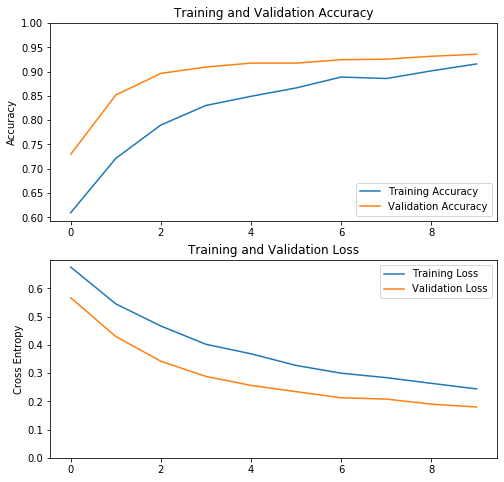

In [44]:
acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,max(plt.ylim())])
plt.title('Training and Validation Loss')
plt.show()

## ファインチューニング
特徴抽出実験では、MobileNet V2ベースモデルの上にいくつかのレイヤーのみをトレーニングしていました。事前トレーニング済みネットワークの重みは、トレーニング中に更新されませんでした。パフォーマンスをさらに向上させる1つの方法は、トップレベルの分類器のトレーニングと一緒に、事前トレーニング済みモデルのトップレイヤーの重みを「微調整」することです。トレーニングプロセスにより、一般的な機能マップから、特にデータセットに関連付けられている機能に重みが調整されます。                         
                               
                               
注：これは、事前トレーニング済みモデルをトレーニング不可に設定して最上位分類器をトレーニングした後にのみ試行する必要があります。事前に訓練されたモデルの上にランダムに初期化された分類器を追加し、すべてのレイヤーを共同で訓練しようとすると、勾配更新の大きさが大きくなり（分類器からのランダムな重みのため）、事前に訓練されたモデルが学んだことをすべて忘れてください。                       
                                  
                                  
さらに、事前学習済みモデルのすべてのレイヤーではなく、事前学習済みモデルの最上位レイヤーを微調整する理由は次のとおりです。convnetでは、レイヤーが上位になるほど、より特殊化されます。convnetの最初の数層は、ほとんどすべての種類の画像に一般化される非常にシンプルで一般的な機能を学びました。しかし、上に行くほど、モデルがトレーニングされたデータセットに固有の機能が増えています。微調整の目標は、これらの特殊な機能を新しいデータセットで動作するように適合させることです。

### モデルの最上層の固定を解除します
必要なのはbase_model、をフリーズ解除し、最下層をトレーニング不能に設定することだけです。次に、モデルを再コンパイルし（これらの変更を有効にするために必要）、トレーニングを再開します。

In [45]:
base_model.trainable = True  #FC層から下流も使う
#基本モデルにいくつのレイヤーがあるか見てみましょう
print("Number of layers in the base model: ", len(base_model.layers))

#このレイヤー以降をFine tuning
fine_tune_at = 100

#`fine_tune_at`レイヤーの前のすべてのレイヤーをフリーズします
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable =  False

Number of layers in the base model:  155


### モデルをコンパイルする
はるかに低いトレーニングレートを使用してモデルをコンパイルします。

In [46]:
model.compile(optimizer = tf.keras.optimizers.RMSprop(lr=2e-5),
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_160 (Model) (None, 5, 5, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1280)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 1281      
Total params: 2,259,265
Trainable params: 1,863,873
Non-trainable params: 395,392
_________________________________________________________________


In [47]:
len(model.trainable_variables)

58

#### モデルのトレーニングを続ける
先に収束するようにトレーニングした場合、これにより、数パーセントの精度が向上します。

In [48]:
history_fine = model.fit_generator(train_generator,
                                   steps_per_epoch = steps_per_epoch,
                                   epochs=epochs,
                                   workers=4,
                                   validation_data=validation_generator,
                                   validation_steps=validation_steps)

Epoch 1/10
62/62 [==============================] - 286s 5s/step - loss: 0.1595 - acc: 0.9487 - val_loss: 0.0940 - val_acc: 0.9688
Epoch 2/10
62/62 [==============================] - 271s 4s/step - loss: 0.0861 - acc: 0.9746 - val_loss: 0.0830 - val_acc: 0.9728
Epoch 3/10
62/62 [==============================] - 280s 5s/step - loss: 0.0677 - acc: 0.9802 - val_loss: 0.0784 - val_acc: 0.9768
Epoch 4/10
62/62 [==============================] - 284s 5s/step - loss: 0.0427 - acc: 0.9914 - val_loss: 0.0815 - val_acc: 0.9718
Epoch 5/10
62/62 [==============================] - 266s 4s/step - loss: 0.0400 - acc: 0.9903 - val_loss: 0.0935 - val_acc: 0.9677
Epoch 6/10
62/62 [==============================] - 271s 4s/step - loss: 0.0243 - acc: 0.9944 - val_loss: 0.0955 - val_acc: 0.9677
Epoch 7/10
62/62 [==============================] - 270s 4s/step - loss: 0.0165 - acc: 0.9959 - val_loss: 0.1033 - val_acc: 0.9667
Epoch 8/10
62/62 [==============================] - 272s 4s/step - loss: 0.0078 - a

#### 学習曲線
MobileNet V2ベースモデルの最後の数層とその上の分類子を微調整するときの、トレーニングと検証の精度/損失の学習曲線を見てみましょう。検証の損失はトレーニングの損失よりもはるかに大きいことに注意してください。

注：トレーニングデータセットはかなり小さく、MobileNet V2がトレーニングされた元のデータセットに似ているため、微調整を行うとオーバーフィットする可能性があります。

収束（epochs=50）にトレーニングすると、結果のグラフは次のようになります。

In [49]:
acc += history_fine.history['acc']
val_acc += history_fine.history['val_acc']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

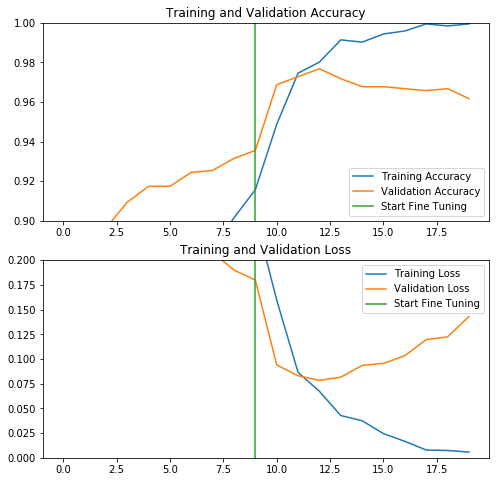

In [50]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.9, 1])
plt.plot([epochs-1,epochs-1], plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 0.2])
plt.plot([epochs-1,epochs-1], plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### 重要なポイント
要約すると、精度を向上させるために事前トレーニング済みモデルを使用して転送学習を行う方法に関するこのチュートリアルでカバーした内容です：* 特徴抽出に事前トレーニング済みモデルを使用-小さなデータセットを使用する場合、一般的に同じドメイン内のより大きなデータセットでトレーニングされたモデルによって学習された機能。これは、事前にトレーニングされたモデルをインスタンス化し、完全に接続された分類器を上に追加することにより行われます。事前に訓練されたモデルは「凍結」されており、分類器の重みのみが訓練中に更新されます。この場合、畳み込みベースは各画像に関連付けられているすべての特徴を抽出し、これらの特徴のセットがどのクラスに属しているかを判断する分類器をトレーニングします。* 微調整事前トレーニング済みモデル-パフォーマンスをさらに向上させるために、事前調整済みモデルの最上位レイヤーを新しいデータセットに再調整して再利用することができます。この場合、データセット固有の高度に指定された高レベルの特徴を学習するように重みを調整します。これは、トレーニングデータセットが大きく、事前トレーニングモデルがトレーニングされた元のデータセットと非常によく似ている場合にのみ意味があります。

# ２．異なるフレームワークへの書き換え
Sprint14で作成した4種類のデータセットを扱うTensorFLowのコードを異なるフレームワークに変更していきます。                
* Iris（Iris-versicolorとIris-virginicaのみの2値分類）             
* Iris（3種類全ての目的変数を使用して多値分類）
* House Prices
* MNIST
### Kerasへの書き換え
KerasはTensorFLowに含まれるtf.kerasモジュールを使用してください。                                   
KerasにはSequentialモデルかFunctional APIかなど書き方に種類がありますが、これは指定しません。

# 【問題２】Irisの２値分類
#### ２値分類の出力層の活性化関数の違い
* ２値分類One-Hot表現にしていない場合・・・sigmoidを通して，0.5以上を１未満を0とする
* ２値分類をOne-Hot表現にした場合・・・softmaxを通して，一番大きい確率のラベルに振り分ける

In [73]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

In [82]:
# データセットの読み込み
df = pd.read_csv('Iris.csv')
# データフレームから条件抽出
df = df[(df["Species"] == "Iris-versicolor")|(df["Species"] == "Iris-virginica")]
y = df["Species"]
X = df.loc[:, ["SepalLengthCm", "SepalWidthCm", "PetalLengthCm", "PetalWidthCm"]]
y = np.array(y)
X = np.array(X)
# ラベルを数値に変換
y[y=='Iris-versicolor'] = 0
y[y=='Iris-virginica'] = 1
y = y.astype(np.int)[:, np.newaxis]

# trainとtestに分割
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
# さらにtrainとvalに分割
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=0)

print('X_shape:',X_train.shape)
print('y_shape',y_train.shape)

X_shape: (64, 4)
y_shape (64, 1)


In [83]:
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.optimizers import Adam
import tensorflow as tf
from keras import backend as K

In [84]:
# ハイパーパラメータの設定
lr = 0.01
batch_size = 5
num_epochs = 100

n_input = X_train.shape[1]     #入力層のノード数
n_samples = X_train.shape[0]   #サンプル数
n_output = y_train.shape[1]    #出力層のノード数

K.clear_session()
model = Sequential()
model.add(Dense(16, input_dim=n_input))
model.add(Activation('sigmoid'))
model.add(Dense(n_output))
model.add(Activation('sigmoid')) 

model.summary()
model.compile(optimizer=Adam(lr),loss='binary_crossentropy',metrics=['accuracy'])

model.fit(X_train,y_train,
          batch_size=batch_size,epochs=num_epochs,verbose=1,
          validation_data=(X_val, y_val))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 16)                80        
_________________________________________________________________
activation_1 (Activation)    (None, 16)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 17        
_________________________________________________________________
activation_2 (Activation)    (None, 1)                 0         
Total params: 97
Trainable params: 97
Non-trainable params: 0
_________________________________________________________________
Train on 64 samples, validate on 16 samples
Epoch 1/100
64/64 [==============================] - 0s 3ms/step - loss: 0.6960 - acc: 0.5469 - val_loss: 0.7073 - val_acc: 0.3750
Epoch 2/100
64/64 [==============================] - 0s 311us/step - loss: 0.6906 - acc: 0.5313 - val_l

In [85]:
y_pred_proba = model.predict(X_test)
y_pred = np.where(y_pred_proba >0.5, 1, 0)
#print("y_pred_proba:\n", y_pred_proba,'\n')
#print("y_pred:\n", y_pred,'\n')

score = model.evaluate(X_test, y_test, verbose=0)
print('loss:', score[0])
print('accuracy:', score[1])

loss: 0.14394626021385193
accuracy: 0.949999988079071


# 【問題3】Iris（多値分類）をKerasで学習

In [94]:
# データセットの読み込み
df = pd.read_csv('Iris.csv')
y = df["Species"]
X = df.loc[:, ["SepalLengthCm", "SepalWidthCm", "PetalLengthCm", "PetalWidthCm"]]
y = np.array(y)
X = np.array(X)
# ラベルを数値に変換
y[y=='Iris-setosa'] = 0
y[y=='Iris-versicolor'] = 1
y[y=='Iris-virginica'] = 2
y = y.astype(np.int)[:, np.newaxis] #整数型に変えて，１列に変換

# trainとtestに分割
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# 正解データをOne-Hot表現に
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder(handle_unknown='error', sparse=False)
y_train_one_hot = enc.fit_transform(y_train[:, :])
y_test_one_hot = enc.transform(y_test[:, :])

# さらにtrainとvalに分割
X_train, X_val, y_train_OH, y_val_OH = train_test_split(X_train, y_train_one_hot, test_size=0.2, random_state=0)

#shapeの確認
print('X_train',X_train.shape)
print('y_train',y_train.shape)
print('y_train_OH',y_train_OH.shape)

# ハイパーパラメータの設定
lr = 0.001
batch_size = 5
num_epochs = 100

n_input = X_train.shape[1]     #入力層のノード数
n_samples = X_train.shape[0]   #サンプル数
n_output = y_train_OH.shape[1]    #出力層のノード数
print(n_input)

X_train (96, 4)
y_train (120, 1)
y_train_OH (96, 3)
4


C:\Users\miyas\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:415: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


In [95]:
#活性化関数にReLUを使うので，重みの初期化にはHeを使う
from keras.initializers import he_normal

K.clear_session()#レイヤの通し番号がつながるの防止

model = Sequential()
model.add(Dense(16, input_dim=n_input, kernel_initializer=he_normal()))#入力層→隠れ層
model.add(Activation('relu')) #活性化層
model.add(Dense(n_output))    #隠れ層→出力層
model.add(Activation('softmax')) 

model.summary()
#コンパイル（多値なのでlossはcategorical_crossentropy）
model.compile(optimizer=Adam(lr), loss='categorical_crossentropy', metrics=['accuracy'])

#学習
model.fit(X_train,y_train_OH,
          batch_size=batch_size,epochs=num_epochs,verbose=1,
          validation_data=(X_val, y_val_OH))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 16)                80        
_________________________________________________________________
activation_1 (Activation)    (None, 16)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 51        
_________________________________________________________________
activation_2 (Activation)    (None, 3)                 0         
Total params: 131
Trainable params: 131
Non-trainable params: 0
_________________________________________________________________
Train on 96 samples, validate on 24 samples
Epoch 1/100
96/96 [==============================] - 0s 2ms/step - loss: 8.7310 - acc: 0.3229 - val_loss: 8.5667 - val_acc: 0.3333
Epoch 2/100
96/96 [==============================] - 0s 197us/step - loss: 7.9083 - acc: 0.3229 - val

In [99]:
y_proba = model.predict(X_test)
y_pred = np.argmax(y_proba,axis=1)
print("y_proba:\n", y_proba[:5],'\n')
print("y_pred:\n", y_pred,'\n')

score = model.evaluate(X_test, y_test_one_hot, verbose=0)
print('loss:', score[0])
print('accuracy:', score[1])

y_proba:
 [[2.3337937e-04 1.2709251e-01 8.7267411e-01]
 [1.1964528e-02 5.9248936e-01 3.9554605e-01]
 [9.9433857e-01 5.6614815e-03 5.4703424e-08]
 [8.1532497e-05 1.0334647e-01 8.9657199e-01]
 [9.7300816e-01 2.6988748e-02 3.0967667e-06]] 

y_pred:
 [2 1 0 2 0 2 0 1 1 1 2 1 1 1 1 0 1 1 0 0 2 1 0 0 2 0 0 1 1 0] 

loss: 0.22005607187747955
accuracy: 1.0


# 【問題4】House PricesをKerasで学習
## データを準備
### １．特徴量を２変数のみに絞り，対数変換

In [207]:
df = pd.read_csv('C:/Users/miyas/kaggle/train.csv')
X = df.loc[:,['GrLivArea','YearBuilt']].values
X_log = np.log(X)
y = df.SalePrice.values
y_log = np.log(y).reshape(-1,1)
print('X_shape:',X_log.shape)
print('y_shape:',y_log.shape)

# trainとtestに分割
X_train_log, X_test_log, y_train_log, y_test_log = train_test_split(X_log, y_log, test_size=0.2, random_state=0)
X_train_log, X_val_log, y_train_log, y_val_log = train_test_split(X_train_log, y_train_log, test_size=0.2, random_state=0)

X_shape: (1460, 2)
y_shape: (1460, 1)


### １．特徴量を２変数のみに絞り，標準化

In [208]:
# trainとtestに分割
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=0)
# 標準化
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
sc.fit(X_train)
X_train_std = sc.transform(X_train)
X_test_std = sc.transform(X_test)
X_val_std = sc.transform(X_val)
sc.fit(y_train[:,np.newaxis])
y_train_std = sc.transform(y_train[:,np.newaxis])
y_test_std = sc.transform(y_test[:,np.newaxis])
y_val_std = sc.transform(y_val[:,np.newaxis])

### ２．特徴量は欠損値とobject型を削除し，標準化

In [195]:
#データ２　欠損値とオブジェクト型は削除して対数変換
#今回は欠損値のある特徴量は削除
df2 = df.dropna(how='any',axis=1)
pd.DataFrame(df2.isna().sum()).T

,Id,MSSubClass,MSZoning,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,...,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [196]:
# object型の個数
object_count = df2.select_dtypes('object').apply(pd.Series.nunique, axis = 0)
object_count

MSZoning          5
Street            2
LotShape          4
LandContour       4
Utilities         2
LotConfig         5
LandSlope         3
Neighborhood     25
Condition1        9
Condition2        8
BldgType          5
HouseStyle        8
RoofStyle         6
RoofMatl          8
Exterior1st      15
Exterior2nd      16
ExterQual         4
ExterCond         5
Foundation        6
Heating           6
HeatingQC         5
CentralAir        2
KitchenQual       4
Functional        7
PavedDrive        3
SaleType          9
SaleCondition     6
dtype: int64

In [197]:
object_col = df2.select_dtypes('object')
data = df2.drop(object_col,axis=1)
data.shape

(1460, 35)

In [204]:
X = data.drop('SalePrice',axis=1).values
y = data.SalePrice.values
X = X.astype(float)
y = y.astype(float)

# trainとtestに分割
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=0)

# 標準化
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
sc.fit(X_train)
X_train_std_1 = sc.transform(X_train)
X_test_std_1 = sc.transform(X_test)
X_val_std_1 = sc.transform(X_val)
sc.fit(y_train[:,np.newaxis])
y_train_std_1 = sc.transform(y_train[:,np.newaxis])
y_test_std_1 = sc.transform(y_test[:,np.newaxis])
y_val_std_1 = sc.transform(y_val[:,np.newaxis])

print('X_shape',X_train_std_1.shape)
print('y_shape',y_val_std_1.shape)

X_shape (934, 34)
y_shape (234, 1)


### ３．欠損列は削除，object型はOne-Hotしたりして標準化

In [200]:
from sklearn.preprocessing import LabelEncoder
# ラベルエンコーダーをインスタンス化
le = LabelEncoder()
le_count = 0

# Iterate through the columns
for col in df2:
    if df2[col].dtype == 'object':
        # If 2 or fewer unique categories
        if len(list(df2[col].unique())) <= 2:
            # Train on the training data
            le.fit(df2[col])
            # Transform both training and test_data2ing data
            df2[col] = le.transform(df2[col])
            
            # Keep track of how many columns were label encoded
            le_count += 1
            
print('%d columns were label encoded.' % le_count)
print('Features shape: ', df2.shape)

3 columns were label encoded.
Features shape:  (1460, 62)


C:\Users\miyas\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [203]:
# one-hotエンコーディング（１列目は削除）
df3 = pd.get_dummies(df2,drop_first=True)
print('Features shape: ', df3.shape)

Features shape:  (1460, 190)


In [205]:
df3 = df3.astype(float)
X = df3.drop('SalePrice',axis=1).values
y = df3.SalePrice.values

# trainとtestに分割
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=0)

# 標準化
sc = StandardScaler()
sc.fit(X_train)
X_train_std_2 = sc.transform(X_train)
X_test_std_2 = sc.transform(X_test)
X_val_std_2 = sc.transform(X_val)
sc.fit(y_train[:,np.newaxis])
y_train_std_2 = sc.transform(y_train[:,np.newaxis])
y_test_std_2 = sc.transform(y_test[:,np.newaxis])
y_val_std_2 = sc.transform(y_val[:,np.newaxis])

print('X_shape',X_train_std_2.shape)
print('y_shape',y_val_std_2.shape)

X_shape (934, 189)
y_shape (234, 1)


In [172]:
# ハイパーパラメータの設定
lr = 0.001
batch_size = 20
num_epochs = 100



In [210]:
def liner_model(X,y, X_val,y_val,X_test,y_test):
    n_input = X.shape[1]     #入力層のノード数
    n_output = y.shape[1]    #出力層のノード数
    
    K.clear_session()
    
    model = Sequential()
    model.add(Dense(16, input_dim=n_input,  kernel_initializer=he_normal()))#入力層→隠れ層
    model.add(Activation('relu')) #活性化層
    model.add(Dense(n_output, kernel_initializer=he_normal()))    #隠れ層→出力層
    model.add(Activation('relu')) 

    model.summary()
    #コンパイル(metricsは評価関数)
    model.compile(optimizer=Adam(lr), loss='mean_squared_error', metrics=['mae'])

    #学習
    model.fit(X, y, batch_size=batch_size, epochs=num_epochs, verbose=1,
              validation_data=(X_val, y_val))
    
    # 推定
    y_pred = model.predict(X_test)
    score = model.evaluate(X_test, y_test, verbose=0)
    print('loss(MSE):', score[0])
    print('MAE:', score[1])

In [212]:
#特徴量２変数で対数変換
liner_model(X_train_log,y_train_log,X_val_log,y_val_log,X_test_log,y_test_log)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 16)                48        
_________________________________________________________________
activation_1 (Activation)    (None, 16)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 17        
_________________________________________________________________
activation_2 (Activation)    (None, 1)                 0         
Total params: 65
Trainable params: 65
Non-trainable params: 0
_________________________________________________________________
Train on 934 samples, validate on 234 samples
Epoch 1/100
934/934 [==============================] - 0s 191us/step - loss: 144.7989 - mean_absolute_error: 12.0265 - val_loss: 144.4178 - val_mean_absolute_error: 12.0109
Epoch 2/100
934/934 [==============================] - 0s 3

934/934 [==============================] - 0s 35us/step - loss: 144.7989 - mean_absolute_error: 12.0265 - val_loss: 144.4178 - val_mean_absolute_error: 12.0109
Epoch 91/100
934/934 [==============================] - 0s 39us/step - loss: 144.7989 - mean_absolute_error: 12.0265 - val_loss: 144.4178 - val_mean_absolute_error: 12.0109
Epoch 92/100
934/934 [==============================] - 0s 35us/step - loss: 144.7989 - mean_absolute_error: 12.0265 - val_loss: 144.4178 - val_mean_absolute_error: 12.0109
Epoch 93/100
934/934 [==============================] - 0s 37us/step - loss: 144.7989 - mean_absolute_error: 12.0265 - val_loss: 144.4178 - val_mean_absolute_error: 12.0109
Epoch 94/100
934/934 [==============================] - 0s 36us/step - loss: 144.7989 - mean_absolute_error: 12.0265 - val_loss: 144.4178 - val_mean_absolute_error: 12.0109
Epoch 95/100
934/934 [==============================] - 0s 38us/step - loss: 144.7989 - mean_absolute_error: 12.0265 - val_loss: 144.4178 - val_mean

In [213]:
#特徴量２変数で標準化
liner_model(X_train_std,y_train_std,X_val_std,y_val_std,X_test_std,y_test_std)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 16)                48        
_________________________________________________________________
activation_1 (Activation)    (None, 16)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 17        
_________________________________________________________________
activation_2 (Activation)    (None, 1)                 0         
Total params: 65
Trainable params: 65
Non-trainable params: 0
_________________________________________________________________
Train on 934 samples, validate on 234 samples
Epoch 1/100
934/934 [==============================] - 0s 220us/step - loss: 1.0000 - mean_absolute_error: 0.7303 - val_loss: 0.8704 - val_mean_absolute_error: 0.7059
Epoch 2/100
934/934 [==============================] - 0s 35us/st

Epoch 45/100
934/934 [==============================] - 0s 35us/step - loss: 1.0000 - mean_absolute_error: 0.7303 - val_loss: 0.8704 - val_mean_absolute_error: 0.7059
Epoch 46/100
934/934 [==============================] - 0s 35us/step - loss: 1.0000 - mean_absolute_error: 0.7303 - val_loss: 0.8704 - val_mean_absolute_error: 0.7059
Epoch 47/100
934/934 [==============================] - 0s 39us/step - loss: 1.0000 - mean_absolute_error: 0.7303 - val_loss: 0.8704 - val_mean_absolute_error: 0.7059
Epoch 48/100
934/934 [==============================] - 0s 43us/step - loss: 1.0000 - mean_absolute_error: 0.7303 - val_loss: 0.8704 - val_mean_absolute_error: 0.7059
Epoch 49/100
934/934 [==============================] - 0s 37us/step - loss: 1.0000 - mean_absolute_error: 0.7303 - val_loss: 0.8704 - val_mean_absolute_error: 0.7059
Epoch 50/100
934/934 [==============================] - 0s 41us/step - loss: 1.0000 - mean_absolute_error: 0.7303 - val_loss: 0.8704 - val_mean_absolute_error: 0.705

934/934 [==============================] - 0s 37us/step - loss: 1.0000 - mean_absolute_error: 0.7303 - val_loss: 0.8704 - val_mean_absolute_error: 0.7059
Epoch 95/100
934/934 [==============================] - 0s 39us/step - loss: 1.0000 - mean_absolute_error: 0.7303 - val_loss: 0.8704 - val_mean_absolute_error: 0.7059
Epoch 96/100
934/934 [==============================] - 0s 39us/step - loss: 1.0000 - mean_absolute_error: 0.7303 - val_loss: 0.8704 - val_mean_absolute_error: 0.7059
Epoch 97/100
934/934 [==============================] - 0s 38us/step - loss: 1.0000 - mean_absolute_error: 0.7303 - val_loss: 0.8704 - val_mean_absolute_error: 0.7059
Epoch 98/100
934/934 [==============================] - 0s 41us/step - loss: 1.0000 - mean_absolute_error: 0.7303 - val_loss: 0.8704 - val_mean_absolute_error: 0.7059
Epoch 99/100
934/934 [==============================] - 0s 43us/step - loss: 1.0000 - mean_absolute_error: 0.7303 - val_loss: 0.8704 - val_mean_absolute_error: 0.7059
Epoch 100/1

In [215]:
#欠損値とobject型は削除して，標準化
liner_model(X_train_std_1,y_train_std_1,X_val_std_1,y_val_std_1,X_test_std_1,y_test_std_1)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 16)                560       
_________________________________________________________________
activation_1 (Activation)    (None, 16)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 17        
_________________________________________________________________
activation_2 (Activation)    (None, 1)                 0         
Total params: 577
Trainable params: 577
Non-trainable params: 0
_________________________________________________________________
Train on 934 samples, validate on 234 samples
Epoch 1/100
934/934 [==============================] - 0s 189us/step - loss: 1.0664 - mean_absolute_error: 0.8285 - val_loss: 0.8361 - val_mean_absolute_error: 0.7271
Epoch 2/100
934/934 [==============================] - 0s 37us/

Epoch 45/100
934/934 [==============================] - 0s 36us/step - loss: 0.3669 - mean_absolute_error: 0.4682 - val_loss: 0.4208 - val_mean_absolute_error: 0.5217
Epoch 46/100
934/934 [==============================] - 0s 37us/step - loss: 0.3662 - mean_absolute_error: 0.4693 - val_loss: 0.4272 - val_mean_absolute_error: 0.5225
Epoch 47/100
934/934 [==============================] - 0s 34us/step - loss: 0.3656 - mean_absolute_error: 0.4682 - val_loss: 0.4302 - val_mean_absolute_error: 0.5247
Epoch 48/100
934/934 [==============================] - 0s 41us/step - loss: 0.3630 - mean_absolute_error: 0.4669 - val_loss: 0.4230 - val_mean_absolute_error: 0.5251
Epoch 49/100
934/934 [==============================] - 0s 36us/step - loss: 0.3632 - mean_absolute_error: 0.4657 - val_loss: 0.4224 - val_mean_absolute_error: 0.5237
Epoch 50/100
934/934 [==============================] - 0s 36us/step - loss: 0.3633 - mean_absolute_error: 0.4662 - val_loss: 0.4302 - val_mean_absolute_error: 0.525

934/934 [==============================] - 0s 47us/step - loss: 0.3349 - mean_absolute_error: 0.4431 - val_loss: 0.4296 - val_mean_absolute_error: 0.5310
Epoch 95/100
934/934 [==============================] - 0s 40us/step - loss: 0.3342 - mean_absolute_error: 0.4424 - val_loss: 0.4270 - val_mean_absolute_error: 0.5307
Epoch 96/100
934/934 [==============================] - 0s 43us/step - loss: 0.3342 - mean_absolute_error: 0.4423 - val_loss: 0.4271 - val_mean_absolute_error: 0.5297
Epoch 97/100
934/934 [==============================] - 0s 37us/step - loss: 0.3345 - mean_absolute_error: 0.4413 - val_loss: 0.4278 - val_mean_absolute_error: 0.5297
Epoch 98/100
934/934 [==============================] - 0s 41us/step - loss: 0.3336 - mean_absolute_error: 0.4412 - val_loss: 0.4290 - val_mean_absolute_error: 0.5308
Epoch 99/100
934/934 [==============================] - 0s 38us/step - loss: 0.3326 - mean_absolute_error: 0.4407 - val_loss: 0.4253 - val_mean_absolute_error: 0.5286
Epoch 100/1

In [216]:
#欠損値は削除，object型はOne-Hotとかして，標準化
liner_model(X_train_std_2,y_train_std_2,X_val_std_2,y_val_std_2,X_test_std_2,y_test_std_2)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 16)                3040      
_________________________________________________________________
activation_1 (Activation)    (None, 16)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 17        
_________________________________________________________________
activation_2 (Activation)    (None, 1)                 0         
Total params: 3,057
Trainable params: 3,057
Non-trainable params: 0
_________________________________________________________________
Train on 934 samples, validate on 234 samples
Epoch 1/100
934/934 [==============================] - 0s 210us/step - loss: 0.7383 - mean_absolute_error: 0.6416 - val_loss: 0.5318 - val_mean_absolute_error: 0.6004
Epoch 2/100
934/934 [==============================] - 0s 4

Epoch 45/100
934/934 [==============================] - 0s 42us/step - loss: 0.3314 - mean_absolute_error: 0.4296 - val_loss: 0.4499 - val_mean_absolute_error: 0.5463
Epoch 46/100
934/934 [==============================] - 0s 43us/step - loss: 0.3297 - mean_absolute_error: 0.4264 - val_loss: 0.4547 - val_mean_absolute_error: 0.5491
Epoch 47/100
934/934 [==============================] - 0s 42us/step - loss: 0.3303 - mean_absolute_error: 0.4283 - val_loss: 0.4489 - val_mean_absolute_error: 0.5472
Epoch 48/100
934/934 [==============================] - 0s 41us/step - loss: 0.3301 - mean_absolute_error: 0.4264 - val_loss: 0.4549 - val_mean_absolute_error: 0.5500
Epoch 49/100
934/934 [==============================] - 0s 41us/step - loss: 0.3308 - mean_absolute_error: 0.4271 - val_loss: 0.4464 - val_mean_absolute_error: 0.5443
Epoch 50/100
934/934 [==============================] - 0s 42us/step - loss: 0.3305 - mean_absolute_error: 0.4269 - val_loss: 0.4528 - val_mean_absolute_error: 0.549

934/934 [==============================] - 0s 46us/step - loss: 0.3237 - mean_absolute_error: 0.4136 - val_loss: 0.4635 - val_mean_absolute_error: 0.5557
Epoch 95/100
934/934 [==============================] - 0s 38us/step - loss: 0.3238 - mean_absolute_error: 0.4141 - val_loss: 0.4625 - val_mean_absolute_error: 0.5560
Epoch 96/100
934/934 [==============================] - 0s 40us/step - loss: 0.3241 - mean_absolute_error: 0.4146 - val_loss: 0.4677 - val_mean_absolute_error: 0.5582
Epoch 97/100
934/934 [==============================] - 0s 38us/step - loss: 0.3251 - mean_absolute_error: 0.4178 - val_loss: 0.4658 - val_mean_absolute_error: 0.5564
Epoch 98/100
934/934 [==============================] - 0s 38us/step - loss: 0.3245 - mean_absolute_error: 0.4152 - val_loss: 0.4677 - val_mean_absolute_error: 0.5569
Epoch 99/100
934/934 [==============================] - 0s 40us/step - loss: 0.3239 - mean_absolute_error: 0.4137 - val_loss: 0.4680 - val_mean_absolute_error: 0.5579
Epoch 100/1

# 【問題5】MNISTをKerasで学習

In [217]:
# MNISTデータのダウンロード
from keras.datasets import mnist
(X_train, y_train), (X_test, y_test) = mnist.load_data()
# 平滑化
X_train = X_train.reshape(-1, 784)
X_test = X_test.reshape(-1, 784)
# 型の変換
X_train = X_train.astype(np.float)
X_test = X_test.astype(np.float)
X_train /= 255
X_test /= 255

# 正解データをOne-Hot表現に
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder(handle_unknown='ignore', sparse=False)
y_train_one_hot = enc.fit_transform(y_train[:, np.newaxis])
y_test_one_hot = enc.transform(y_test[:, np.newaxis])

# trainデータをtrainとvalに分ける
from sklearn.model_selection import train_test_split
X_train, X_val, y_train_OH, y_val_OH = train_test_split(X_train, y_train_one_hot, test_size=0.2)

#shapeの確認
print('y_train_shape',y_train.shape) # (60000,)
print('y_train_one_hot_shape',y_train_OH.shape) # (60000, 10)
print('y_train_one_hot_dtype:',y_train_one_hot.dtype) # float64
print('X_train_shape',X_train.shape)

y_train_shape (60000,)
y_train_one_hot_shape (48000, 10)
y_train_one_hot_dtype: float64
X_train_shape (48000, 784)


In [218]:
# ハイパーパラメータの設定
lr = 0.001
batch_size = 20
num_epochs = 100

n_input = X_train.shape[1]     #入力層のノード数
n_output = y_train_OH.shape[1]    #出力層のノード数
print(n_input)

K.clear_session()#レイヤの通し番号がつながるの防止

model = Sequential()
model.add(Dense(16, input_dim=n_input, kernel_initializer=he_normal()))#入力層→隠れ層
model.add(Activation('relu')) #活性化層
model.add(Dense(n_output))    #隠れ層→出力層
model.add(Activation('softmax')) 

model.summary()
#コンパイル（多値なのでlossはcategorical_crossentropy）
model.compile(optimizer=Adam(lr), loss='categorical_crossentropy', metrics=['accuracy'])

#学習
model.fit(X_train,y_train_OH,
          batch_size=batch_size,epochs=num_epochs,verbose=1,
          validation_data=(X_val, y_val_OH))

784
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 16)                12560     
_________________________________________________________________
activation_1 (Activation)    (None, 16)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 10)                170       
_________________________________________________________________
activation_2 (Activation)    (None, 10)                0         
Total params: 12,730
Trainable params: 12,730
Non-trainable params: 0
_________________________________________________________________
Train on 48000 samples, validate on 12000 samples
Epoch 1/100
48000/48000 [==============================] - 3s 53us/step - loss: 0.4019 - acc: 0.8866 - val_loss: 0.2676 - val_acc: 0.9223
Epoch 2/100
48000/48000 [==============================] - 2s 48us/step - loss

In [219]:
# 推定
score = model.evaluate(X_test, y_test_one_hot, verbose=0)
print('loss(MSE):', score[0])
print('accuracy:', score[1])

loss(MSE): 0.2952535346505465
MAE: 0.9473


# 【問題6】（アドバンス課題）PyTorchへの書き換え